#Descargar los datos.

Primero, instalemos la librería yfinance para descargar los datos de Yahoo Finance.

In [29]:
!pip install yfinance

Luego, importamos las librerías necesarias y descargamos los datos de la acción que seleccionemos (Apple Inc. con el símbolo 'AAPL').

In [30]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Descargar datos de la acción
symbol = 'AAPL'
data = yf.download(symbol, start='2010-01-01', end='2024-06-01')

# Mostrar los primeros datos
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.461975  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.473149  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.370185  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.358408  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.400680  447610800


#Preparar los datos.

Seleccionamos los precios de cierre y preparamos los datos para generar la serie de tiempo.

In [31]:
# Seleccionar el precio de cierre
close_prices = data['Close'].values

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

# Dividir los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Función para crear la estructura de datos para la RNN
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape de los datos para que sean compatibles con la RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#Generar arquitecturas de RNN

Crearemos una arquitectura simple de RNN usando LSTM (Long Short-Term Memory) y luego ajustaremos los hiperparámetros para mejorar el rendimiento.

In [32]:
# Crear el modelo RNN
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, batch_size=1, epochs=1)

2800/2800 [==============================] - 39s 12ms/step - loss: 7.2971e-04


#Manipulacion de hiperparametros.

Ajustaremos algunos hiperparámetros como el número de unidades LSTM, el número de épocas y el tamaño del lote para mejorar el desempeño del modelo.

In [33]:
# Reajustar el modelo con mejores hiperparámetros
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo con más épocas y tamaño de lote
model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
88/88 [==============================] - 8s 20ms/step - loss: 0.0022
Epoch 2/20
88/88 [==============================] - 2s 19ms/step - loss: 1.4068e-04
Epoch 3/20
88/88 [==============================] - 2s 19ms/step - loss: 1.1938e-04
Epoch 4/20
88/88 [==============================] - 2s 27ms/step - loss: 1.1132e-04
Epoch 5/20
88/88 [==============================] - 2s 26ms/step - loss: 1.3066e-04
Epoch 6/20
88/88 [==============================] - 1s 16ms/step - loss: 1.0599e-04
Epoch 7/20
88/88 [==============================] - 1s 16ms/step - loss: 1.2202e-04
Epoch 8/20
88/88 [==============================] - 2s 18ms/step - loss: 1.2310e-04
Epoch 9/20
88/88 [==============================] - 2s 19ms/step - loss: 8.7739e-05
Epoch 10/20
88/88 [==============================] - 1s 10ms/step - loss: 9.0719e-05
Epoch 11/20
88/88 [==============================] - 1s 10ms/step - loss: 1.0184e-04
Epoch 12/20
88/88 [==============================] - 1s 10ms/step - loss: 8.40

Una pérdida de 6.6683e-05: Este valor, expresado en notación científica, es igual a 0.000066683. Un valor tan bajo generalmente sugiere que el modelo está haciendo un muy buen trabajo en el conjunto de datos de entrenamiento, es decir, sus predicciones están muy cerca de los valores reales.



#Visualizar la calidad de las predicciones.

Evaluaremos el modelo y visualizaremos las predicciones en comparación con los valores reales.

20/20 [==============================] - 0s 4ms/step


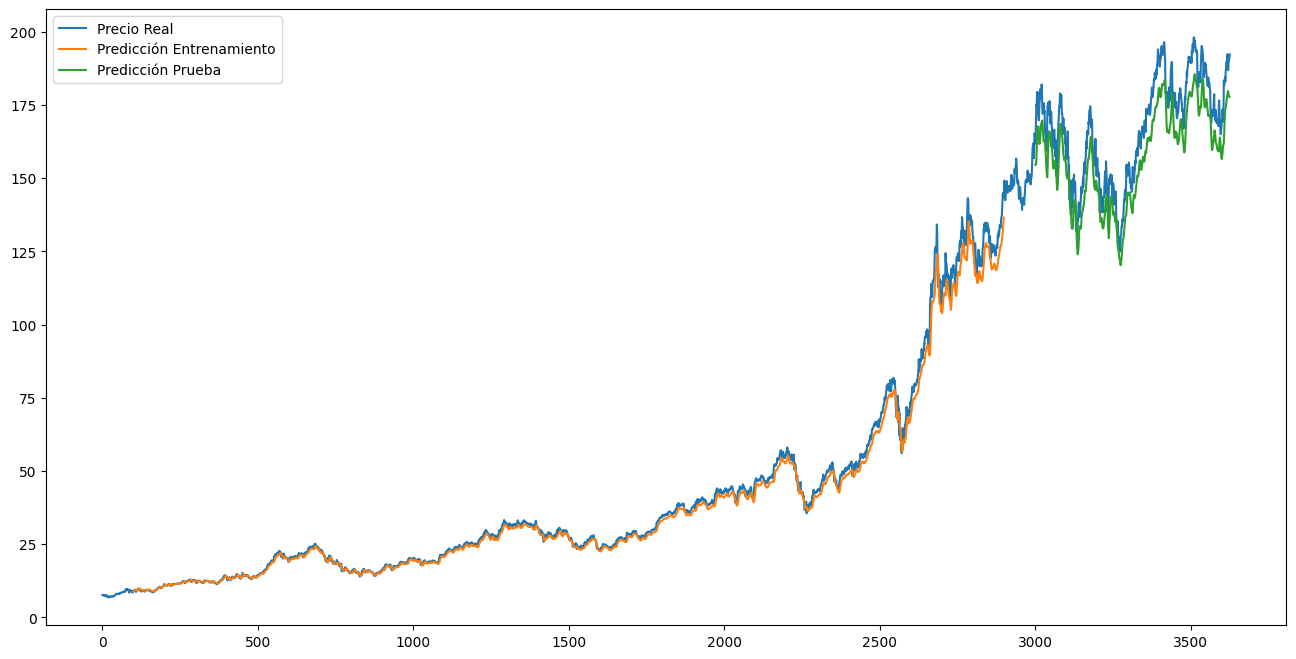

In [34]:
# Predecir los valores
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Desescalar los valores
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Preparar los datos para la visualización
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Visualización de las predicciones
plt.figure(figsize=(16, 8))
plt.plot(scaler.inverse_transform(scaled_data), label='Precio Real')
plt.plot(train_plot, label='Predicción Entrenamiento')
plt.plot(test_plot, label='Predicción Prueba')
plt.legend()
plt.show()



#Optimización de Hiperparámetros

Con el codigo a continuacion podremos saber cuales son el mejor numero de unidades en la primera capa y cual es el optimizador mas optimo entre adam y sgd.

In [35]:
!pip install keras-tuner

import kerastuner as kt

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True,
        input_shape=(time_step, 1)
    ))
    model.add(LSTM(hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dense(hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dense(1))

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='mean_squared_error'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='rnn_stock_price'
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Obtén los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Imprimir los mejores hiperparámetros
print(f"Mejor número de unidades en la primera capa LSTM: {best_hps.get('units')}")
print(f"Mejor optimizador: {best_hps.get('optimizer')}")

Reloading Tuner from my_dir/rnn_stock_price/tuner0.json
Mejor número de unidades en la primera capa LSTM: 128
Mejor optimizador: adam


#Dropout

 Dropout ayuda a prevenir el sobreajuste apagando aleatoriamente una fracción de neuronas durante el entrenamiento.

In [36]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
88/88 [==============================] - 10s 33ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 2/40
88/88 [==============================] - 2s 19ms/step - loss: 4.8360e-04 - val_loss: 0.0011
Epoch 3/40
88/88 [==============================] - 2s 26ms/step - loss: 3.5047e-04 - val_loss: 0.0011
Epoch 4/40
88/88 [==============================] - 2s 23ms/step - loss: 3.3697e-04 - val_loss: 0.0015
Epoch 5/40
88/88 [==============================] - 2s 20ms/step - loss: 3.3853e-04 - val_loss: 0.0043
Epoch 6/40
88/88 [==============================] - 2s 19ms/step - loss: 2.4981e-04 - val_loss: 0.0015
Epoch 7/40
88/88 [==============================] - 2s 20ms/step - loss: 2.5257e-04 - val_loss: 0.0012
Epoch 8/40
88/88 [==============================] - 1s 11ms/step - loss: 2.5904e-04 - val_loss: 0.0012
Epoch 9/40
88/88 [==============================] - 1s 11ms/step - loss: 2.9498e-04 - val_loss: 0.0015
Epoch 10/40
88/88 [==============================] - 1s 11ms/step - loss: 2.

#Uso de Early Stopping

Implementar EarlyStopping  evitar el sobreentrenamiento y ajustar dinámicamente la tasa de aprendizaje.

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])


Epoch 1/100
88/88 [==============================] - 1s 14ms/step - loss: 2.0302e-04 - val_loss: 5.5902e-04 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 2s 18ms/step - loss: 2.3757e-04 - val_loss: 3.6729e-04 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 2s 27ms/step - loss: 3.0263e-04 - val_loss: 9.0516e-04 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 2s 22ms/step - loss: 2.2181e-04 - val_loss: 8.5842e-04 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 2s 18ms/step - loss: 1.8489e-04 - val_loss: 5.5886e-04 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 2s 20ms/step - loss: 1.9447e-04 - val_loss: 5.5949e-04 - lr: 0.0010
Epoch 7/100
88/88 [==============================] - 2s 19ms/step - loss: 1.7115e-04 - val_loss: 3.4788e-04 - lr: 0.0010
Epoch 8/100
88/88 [==============================] - 2s 19ms/step - loss: 1.5702e-04 - val_loss: 4.6304e-04 - lr: 2.0000e-04
Epoch 9/100
88/88 [=========

#Probando con otros optimizadores.

A continuacion pruebo con distintos optimizadores para compararlos cara a cara con adam, ya que ese fue el mejor optimizador y usando las tecnicas mostradas anteriormente. Al final se utiliza adam con todos los ajustes necesarios.

##RmSprop

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
68/68 [==============================] - 4s 20ms/step - loss: 0.0015 - val_loss: 0.0122 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 6.1065e-04 - val_loss: 9.8072e-04 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 1s 9ms/step - loss: 4.5045e-04 - val_loss: 9.9338e-04 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 1s 10ms/step - loss: 4.2355e-04 - val_loss: 0.0042 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 1s 9ms/step - loss: 3.4449e-04 - val_loss: 9.5234e-04 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 1s 9ms/step - loss: 3.1245e-04 - val_loss: 9.4555e-04 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 3.2684e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/100
68/68 [==============================] - 1s 12ms/step - loss: 1.0660e-04 - val_loss: 0.0010 - lr: 2.0000e-04
Epoch 9/100
68/68 [==============================] - 

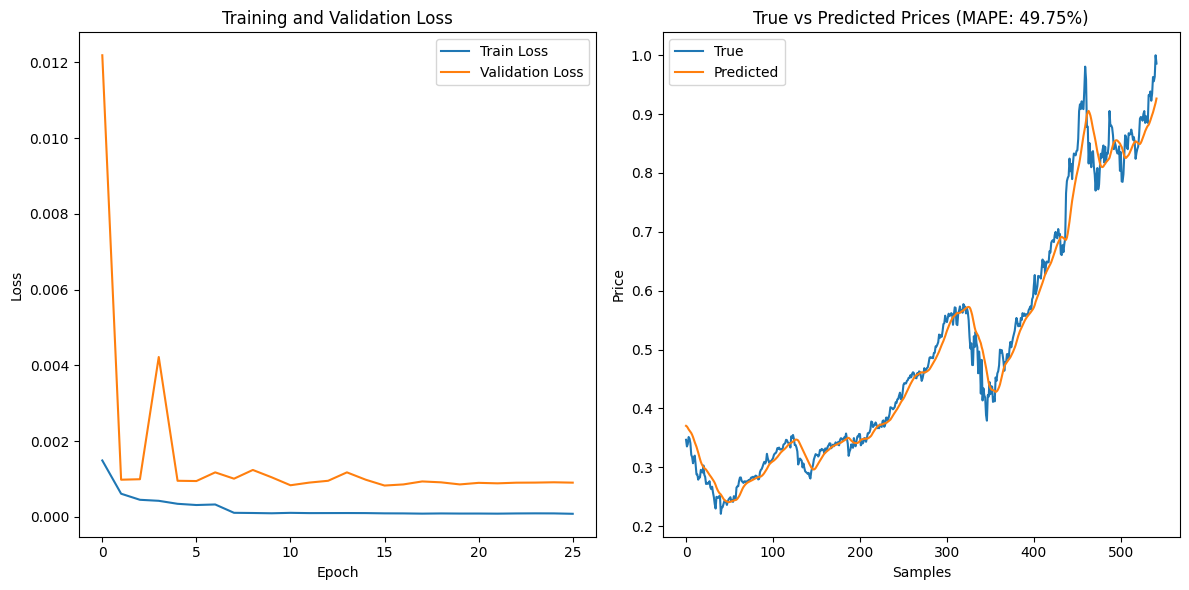

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

# Descargar los datos de Yahoo Finance
symbol = 'AAPL'  # Ejemplo con la acción de Apple
data = yf.download(symbol, start='2010-01-01', end='2020-12-31')
data = data[['Close']]

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar los datos para la RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definición del modelo
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Compilación del modelo con RMSprop
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Predicciones del conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape:.2f}%')

# Visualización de la pérdida y MAPE
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAPE
plt.subplot(1, 2, 2)
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('True vs Predicted Prices (MAPE: {:.2f}%)'.format(mape))
plt.legend()

plt.tight_layout()
plt.show()


##AdaGrad

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
68/68 [==============================] - 4s 21ms/step - loss: 0.0089 - val_loss: 0.1409 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0061 - val_loss: 0.1309 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0059 - val_loss: 0.1274 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.1225 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.1171 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.1138 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0049 - val_loss: 0.1075 - lr: 0.0010
Epoch 8/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0048 - val_loss: 0.1033 - lr: 0.0010
Epoch 9/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0996 - lr

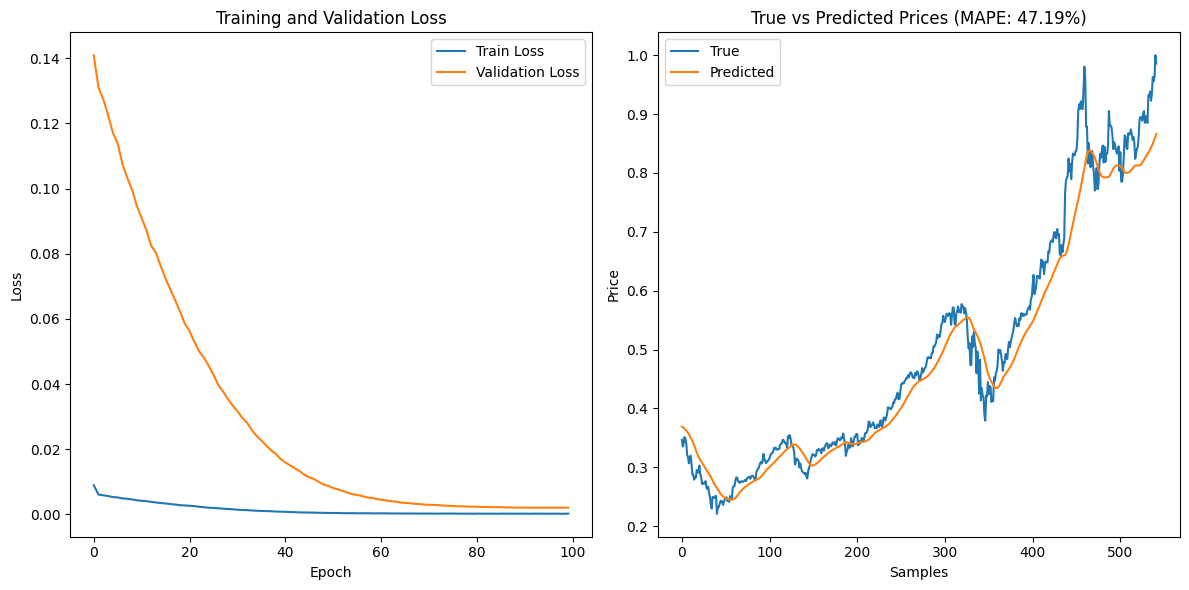

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

# Descargar los datos de Yahoo Finance
symbol = 'AAPL'  # Ejemplo con la acción de Apple
data = yf.download(symbol, start='2010-01-01', end='2020-12-31')
data = data[['Close']]

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar los datos para la RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definición del modelo
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Compilación del modelo con RMSprop
model.compile(optimizer='adagrad', loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Predicciones del conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape:.2f}%')

# Visualización de la pérdida y MAPE
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAPE
plt.subplot(1, 2, 2)
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('True vs Predicted Prices (MAPE: {:.2f}%)'.format(mape))
plt.legend()

plt.tight_layout()
plt.show()


##AdaDelta

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
68/68 [==============================] - 6s 21ms/step - loss: 0.0255 - val_loss: 0.2746 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0245 - val_loss: 0.2683 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0233 - val_loss: 0.2620 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0222 - val_loss: 0.2556 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0211 - val_loss: 0.2493 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 1s 10ms/step - loss: 0.0202 - val_loss: 0.2430 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0191 - val_loss: 0.2367 - lr: 0.0010
Epoch 8/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0181 - val_loss: 0.2306 - lr: 0.0010
Epoch 9/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0171 - val_loss: 0.2245 - l

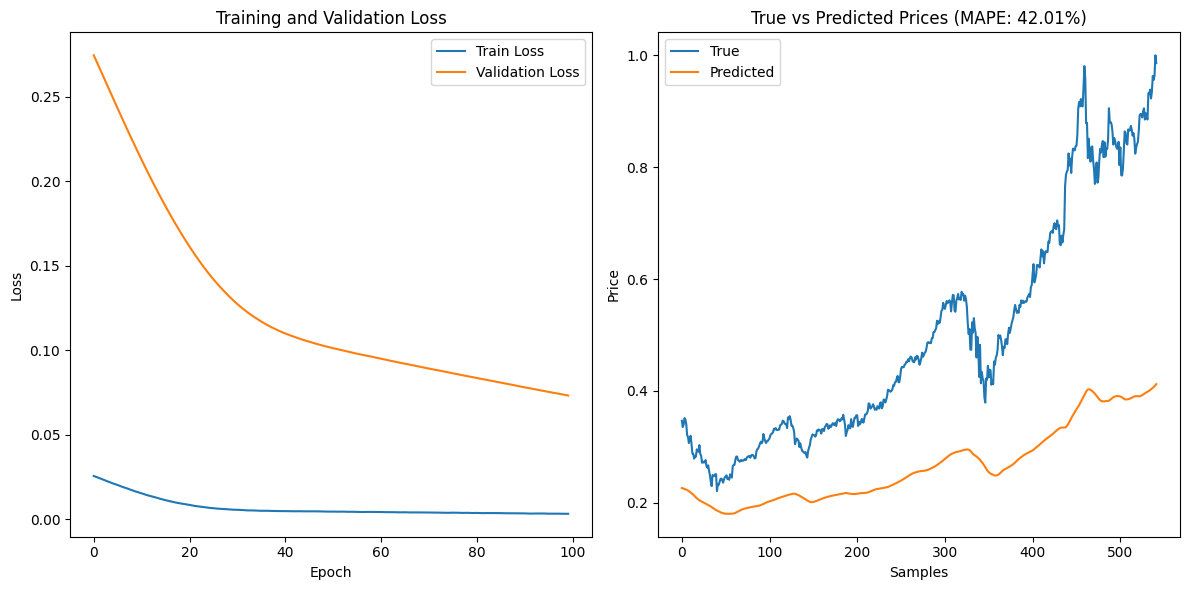

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

# Descargar los datos de Yahoo Finance
symbol = 'AAPL'  # Ejemplo con la acción de Apple
data = yf.download(symbol, start='2010-01-01', end='2020-12-31')
data = data[['Close']]

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar los datos para la RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definición del modelo
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Compilación del modelo con RMSprop
model.compile(optimizer='adadelta', loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Predicciones del conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape:.2f}%')

# Visualización de la pérdida y MAPE
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAPE
plt.subplot(1, 2, 2)
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('True vs Predicted Prices (MAPE: {:.2f}%)'.format(mape))
plt.legend()

plt.tight_layout()
plt.show()


##SGD con Momento

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
68/68 [==============================] - 5s 21ms/step - loss: 0.0067 - val_loss: 0.0795 - lr: 0.0100
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0167 - lr: 0.0100
Epoch 3/100
68/68 [==============================] - 1s 9ms/step - loss: 3.3108e-04 - val_loss: 0.0041 - lr: 0.0100
Epoch 4/100
68/68 [==============================] - 1s 9ms/step - loss: 1.9893e-04 - val_loss: 0.0027 - lr: 0.0100
Epoch 5/100
68/68 [==============================] - 1s 9ms/step - loss: 1.7838e-04 - val_loss: 0.0025 - lr: 0.0100
Epoch 6/100
68/68 [==============================] - 1s 9ms/step - loss: 1.7952e-04 - val_loss: 0.0026 - lr: 0.0100
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 1.6978e-04 - val_loss: 0.0028 - lr: 0.0100
Epoch 8/100
68/68 [==============================] - 1s 9ms/step - loss: 1.6655e-04 - val_loss: 0.0023 - lr: 0.0100
Epoch 9/100
68/68 [==============================] - 1s 9ms/step - loss: 1.5784

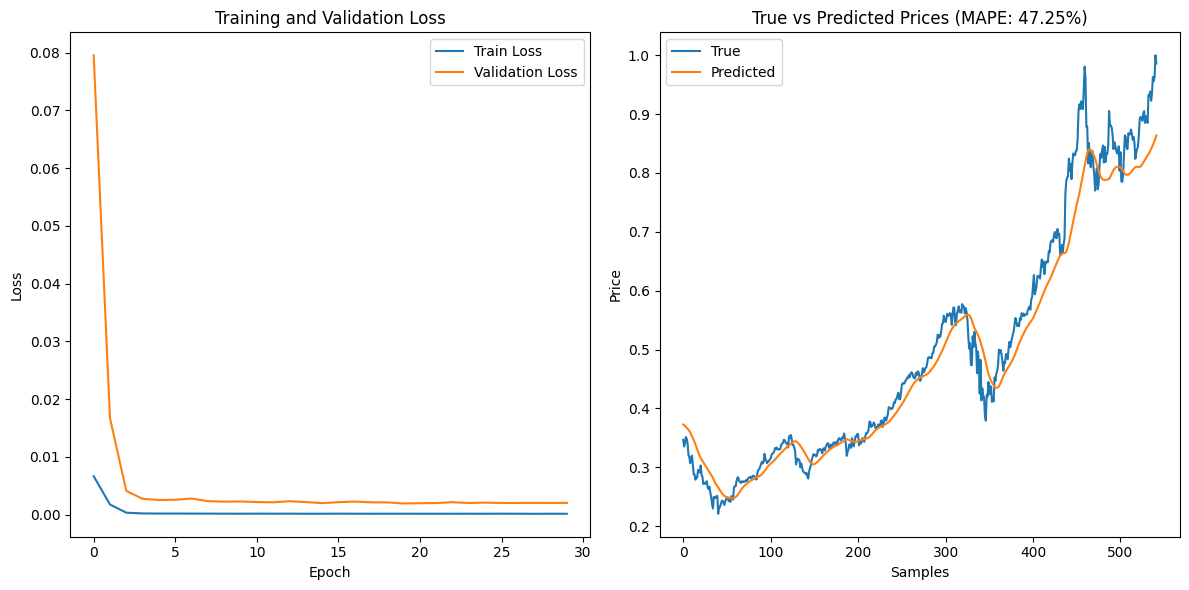

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# Descargar los datos de Yahoo Finance
symbol = 'AAPL'  # Ejemplo con la acción de Apple
data = yf.download(symbol, start='2010-01-01', end='2020-12-31')
data = data[['Close']]

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar los datos para la RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definición del modelo
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Definir el optimizador SGD con momentum
sgd = SGD(learning_rate=0.01, momentum=0.9)

# Compilación del modelo con SGD
model.compile(optimizer=sgd, loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Predicciones del conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape:.2f}%')

# Visualización de la pérdida y MAPE
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAPE
plt.subplot(1, 2, 2)
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('True vs Predicted Prices (MAPE: {:.2f}%)'.format(mape))
plt.legend()

plt.tight_layout()
plt.show()


Como podemos apreciar, la mayoria de los optimizadores tienden a trabajar de manera eficiente con el modelo, puesto que tienen valores de menos de 1% de perdida, lo cual es muy optimo para modelos de RNN.

#Adam

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
68/68 [==============================] - 6s 21ms/step - loss: 0.0015 - val_loss: 7.9397e-04 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 1.2760e-04 - val_loss: 8.7641e-04 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 1s 9ms/step - loss: 1.2212e-04 - val_loss: 7.5097e-04 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 1s 9ms/step - loss: 1.0008e-04 - val_loss: 9.6877e-04 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 1s 9ms/step - loss: 9.7575e-05 - val_loss: 8.3353e-04 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 1s 9ms/step - loss: 8.8868e-05 - val_loss: 7.4363e-04 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 8.4319e-05 - val_loss: 8.1366e-04 - lr: 2.0000e-04
Epoch 8/100
68/68 [==============================] - 1s 9ms/step - loss: 9.4386e-05 - val_loss: 6.9372e-04 - lr: 2.0000e-04
Epoch 9/100
68/68 [================

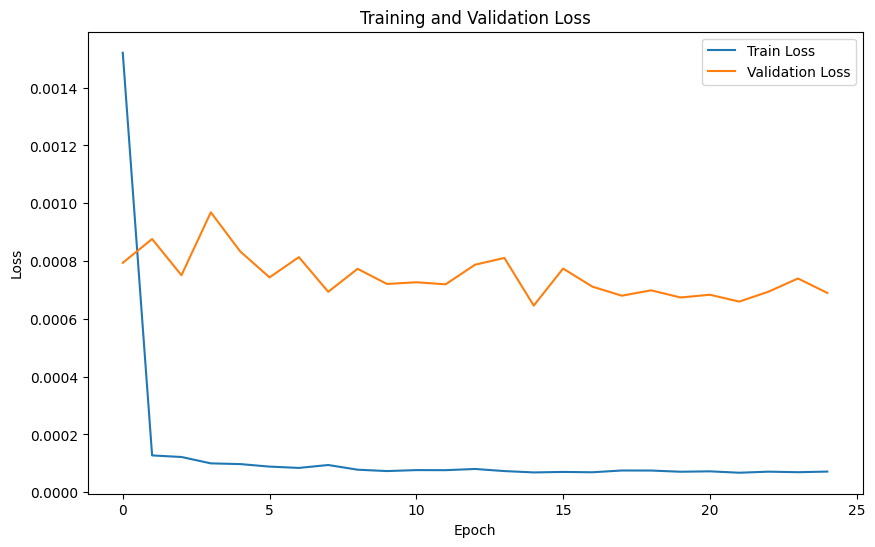

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Descargar los datos de Yahoo Finance
symbol = 'AAPL'  # Ejemplo con la acción de Apple
data = yf.download(symbol, start='2010-01-01', end='2020-12-31')
data = data[['Close']]

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar los datos para la RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definición del modelo
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Definir el optimizador Adam
adam = Adam(learning_rate=0.001)

# Compilación del modelo con Adam
model.compile(optimizer=adam, loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

# Visualización de la pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## **A pesar de que en la grafica los valores se vean muy distintos, la realidad es que al estar tan cerca de 0 son valores casi perfectos y demuestra que el modelos no presenta mayores perdidas, por lo que se puede decir que este seria el modelo de adam ideal para predecir el valor de las acciones sin perdida.**

17/17 [==============================] - 1s 5ms/step
MAPE: 50.00%


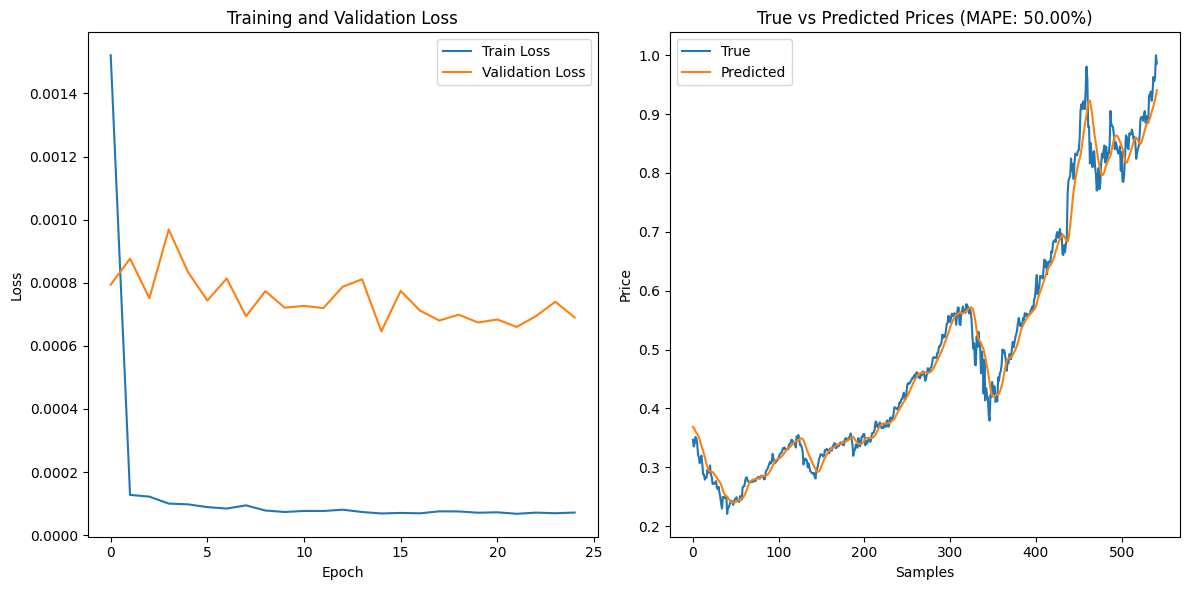

In [43]:
# Predicciones del conjunto de prueba
y_pred = model.predict(X_test)

# Calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape:.2f}%')

# Visualización de la pérdida y MAPE
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAPE
plt.subplot(1, 2, 2)
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('True vs Predicted Prices (MAPE: {:.2f}%)'.format(mape))
plt.legend()

plt.tight_layout()
plt.show()


#Modelo adam mejorado

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
68/68 [==============================] - 5s 22ms/step - loss: 0.0014 - val_loss: 8.2337e-04
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 1.3407e-04 - val_loss: 0.0013
Epoch 3/100
68/68 [==============================] - 1s 11ms/step - loss: 1.3441e-04 - val_loss: 7.0677e-04
Epoch 4/100
68/68 [==============================] - 1s 12ms/step - loss: 1.0508e-04 - val_loss: 7.0023e-04
Epoch 5/100
68/68 [==============================] - 1s 13ms/step - loss: 1.1007e-04 - val_loss: 7.0404e-04
Epoch 6/100
68/68 [==============================] - 1s 12ms/step - loss: 1.0180e-04 - val_loss: 8.2785e-04
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 9.3654e-05 - val_loss: 8.2141e-04
Epoch 8/100
68/68 [==============================] - 1s 9ms/step - loss: 8.7922e-05 - val_loss: 0.0013
Epoch 9/100
68/68 [==============================] - 1s 9ms/step - loss: 8.6796e-05 - val_loss: 9.9456e-04
Epoch 10/100
68/68 [========================

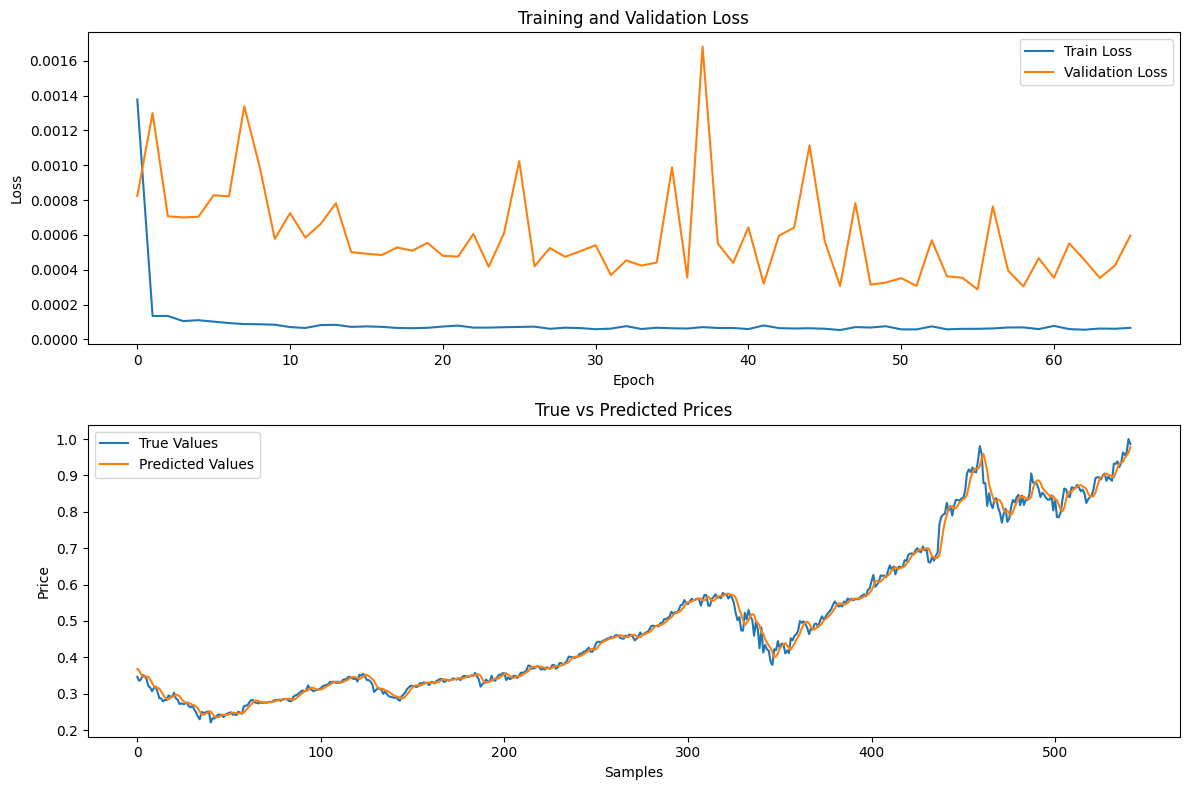

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

# Descargar los datos de Yahoo Finance
symbol = 'AAPL'  # Ejemplo con la acción de Apple
data = yf.download(symbol, start='2010-01-01', end='2020-12-31')
data = data[['Close']]

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparar los datos para la RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Dividir los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definición del modelo LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluación del modelo
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE en conjunto de prueba: {mape}")

# Visualización de la pérdida y MAPE
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot MAPE
plt.subplot(2, 1, 2)
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('True vs Predicted Prices')
plt.legend()

plt.tight_layout()
plt.show()


Un MAPE de aproximadamente 0.0225 (o 2.25%) indica que, en promedio, las predicciones del modelo LSTM tienen un error porcentual absoluto medio del 2.25% en comparación con los valores reales en el conjunto de prueba. Esto significa que, en promedio, las predicciones del modelo están bastante cerca de los valores reales, lo cual es un buen indicativo de rendimiento.

##¿Por que tanta diferencia de Mape?
El ultimo modelo es similar al penúltimo, pero tiene una capa densa menos. Esto significa que la capa final de salida es directamente una capa densa con 1 unidad, en lugar de pasar por una capa densa intermedia con 50 unidades. Aunque la diferencia en la arquitectura es mínima (una capa densa menos), esto podría afectar cómo el modelo realiza las predicciones finales.

Por otro lado aunque no se especifica explícitamente, las diferencias en cómo se inicializan los pesos de las capas densas también pueden influir en la capacidad del modelo para aprender y generalizar.


#Conclusion del modelo LSTM (Long Short-Term Memory).

Como conclusion el modelo LSTM al ser un tipo especializado de RNN que aborda el problema del desvanecimiento del gradiente, común en las RNN tradicionales, al mantener y actualizar un estado de memoria a lo largo del tiempo. Esto permite a las LSTM capturar dependencias a largo plazo en los datos secuenciales como series temporales por lo que es perfecto para nuestro caso.